In [1]:
import pandas as pd
import numpy as np
from random import choice

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

import re
import nltk
from rake_nltk import Rake
#nltk.download('stopwords')

import lda
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
google_grossing = pd.read_json('googleplay_free.json')[800:900]
col_n = ['category', 'description', 'details', 'title']
google_grossing = pd.DataFrame(google_grossing, columns = col_n)
google_grossing.head()

,category,description,details,title
800,"[Tinder,Lifestyle]","Find friends, dates, relationships and everyth...","With 30 billion matches to date, Tinder® is th...",1. Tinder
801,"[King,Casual]",The sweetest match 3 puzzle game! Switch and s...,"Spring has sprung in Candy Crush Saga, switch ...",2. Candy Crush Saga
802,"[Google LLC,Productivity]","Expanded storage, access to experts and more –...",Google One is a simple plan for expanded stora...,3. Google One
803,"[Moon Active,Casual]",Play the Best Adventure Game with Friends !!!,Join your Facebook friends and millions of pla...,4. Coin Master
804,"[Roblox Corporation,Adventure,Action & Adventure]","Roblox lets you play, create, and be anything ...",* LIMITED TIME ONLY (November 25 – March 31): ...,5. Roblox


In [3]:
def clean_category(x):
    x = str(x)
    pos1 = x.find(',')
    pos2 = x[pos1+1:].find(',')
    if pos1 == -1:
        return x[1:-1]
    if pos2 == -1:
        return x[pos1+1:-1]
    return x[pos1+1:pos2]

google_grossing['category'] = google_grossing['category'].map(clean_category)
google_grossing.dropna()

clean_title = lambda x: str(x)[3:].strip()
google_grossing['title'] = google_grossing['title'].map(clean_title)
google_grossing.head()

,category,description,details,title
800,Lifestyle,"Find friends, dates, relationships and everyth...","With 30 billion matches to date, Tinder® is th...",Tinder
801,Casual,The sweetest match 3 puzzle game! Switch and s...,"Spring has sprung in Candy Crush Saga, switch ...",Candy Crush Saga
802,Productivity,"Expanded storage, access to experts and more –...",Google One is a simple plan for expanded stora...,Google One
803,Casual,Play the Best Adventure Game with Friends !!!,Join your Facebook friends and millions of pla...,Coin Master
804,,"Roblox lets you play, create, and be anything ...",* LIMITED TIME ONLY (November 25 – March 31): ...,Roblox


In [4]:
google_category = google_grossing['category'].tolist()
google_description = google_grossing['description'].tolist()
google_details = google_grossing['details'].tolist()
google_title = google_grossing['title'].tolist()

google_grossing['category'].unique()

array(['Lifestyle', 'Casual', 'Productivity', '', 'Strategy', 'Action',
       'Role Playing', 'Puzzle', 'Sports', 'Casino', 'Card', 'Simulation',
       'Social', 'Tools', 'Word', 'Entertainment', 'Music & Audio',
       'Adventure', 'Racing', ' ', 'Health & Fitness'], dtype=object)

In [5]:
google_grossing_category=google_grossing[~google_grossing['category'].isin([' ', ''])]

google_category_category = google_grossing_category['category'].tolist()
google_description_category = google_grossing_category['description'].tolist()
google_details_category = google_grossing_category['details'].tolist()
google_title_category = google_grossing_category['title'].tolist()

google_grossing_category['category'].unique()

array(['Lifestyle', 'Casual', 'Productivity', 'Strategy', 'Action',
       'Role Playing', 'Puzzle', 'Sports', 'Casino', 'Card', 'Simulation',
       'Social', 'Tools', 'Word', 'Entertainment', 'Music & Audio',
       'Adventure', 'Racing', 'Health & Fitness'], dtype=object)

In [6]:
def my_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return choice(["rgb(94,38,18)", "rgb(41,36,33)", "rgb(128,128,105)", "rgb(112,128,105)"])

def draw_cloud(word_freq):  
    wc = WordCloud(background_color="white",  
                   max_words=800,  
                   max_font_size=80, 
                   random_state=42,
                   )

    wc.generate_from_frequencies(word_freq)

    plt.figure(figsize=(12,12))

    plt.imshow(wc.recolor(color_func=my_color_func), interpolation='bilinear')

    plt.axis("off")
    plt.show()

In [7]:
adj_raw = ' '.join(google_details) + ' '.join(google_description)

In [8]:
r = Rake()
r.extract_keywords_from_text(adj_raw)
input_freq = r.get_ranked_phrases()[:1000]

In [9]:
tokens = nltk.word_tokenize(' '.join(input_freq))
tags = set(['VBN', 'RBR', 'NNP', 'NNPS', 'JJS', 'JJR', 'JJ', 'FW'])
pos_tags =nltk.pos_tag(tokens)


ret = []
for word,pos in pos_tags:
        if (pos in tags):
            ret.append(word)
adj_input = ' '.join(ret) 

In [10]:
r = Rake()
r.extract_keywords_from_text(adj_input)
input_freq = r.get_word_frequency_distribution()
words_freq = {key: value for key, value in input_freq.items() if len(key)>2}

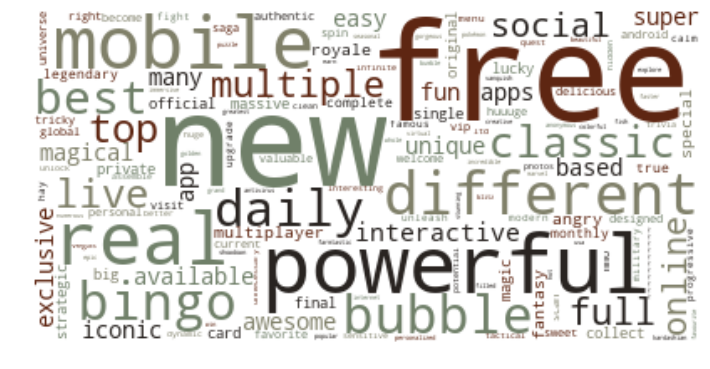

In [11]:
draw_cloud(words_freq)

In [12]:
n_input = ' '.join(google_title)

In [13]:
r = Rake()
r.extract_keywords_from_text(n_input)
input_freq = r.get_word_frequency_distribution()
words_freq = {key: value for key, value in input_freq.items() if len(key)>2}

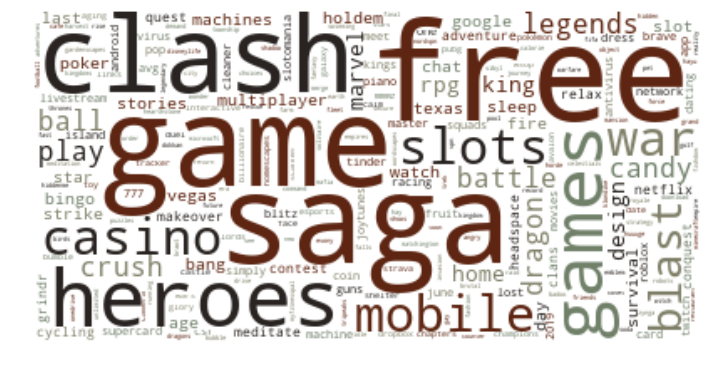

In [14]:
draw_cloud(words_freq)

In [15]:
def get_lda_input(chapters):
    corpus = [" ".join(chapters['title'].tolist())]
    #print (corpus)
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    return X.toarray(), vectorizer

In [16]:
def lda_train(weight, vectorizer, n_topics):
    model = lda.LDA(n_topics=n_topics, n_iter=500, random_state=1)
    model.fit(weight)

    doc_num = len(weight)
    topic_word = model.topic_word_
    vocab = vectorizer.get_feature_names()

    n_top_words = 20
    topics = []
    for i, topic_dist in enumerate(topic_word):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1]
        topics.append(' '.join(topic_words))
        
    return topics

In [17]:
category_topic = {}
for cat in google_grossing_category['category'].unique():
    cat_google_grossing = google_grossing_category[google_grossing_category.category.isin([cat])]
    weight, vectorizer = get_lda_input(cat_google_grossing)
    topic = lda_train(weight, vectorizer, 1)
    category_topic[cat] = topic[0]

INFO:lda:n_documents: 1
INFO:lda:vocab_size: 10
INFO:lda:n_words: 10
INFO:lda:n_topics: 1
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -57
INFO:lda:<10> log likelihood: -57
INFO:lda:<20> log likelihood: -57
INFO:lda:<30> log likelihood: -57
INFO:lda:<40> log likelihood: -57
INFO:lda:<50> log likelihood: -57
INFO:lda:<60> log likelihood: -57
INFO:lda:<70> log likelihood: -57
INFO:lda:<80> log likelihood: -57
INFO:lda:<90> log likelihood: -57
INFO:lda:<100> log likelihood: -57
INFO:lda:<110> log likelihood: -57
INFO:lda:<120> log likelihood: -57
INFO:lda:<130> log likelihood: -57
INFO:lda:<140> log likelihood: -57
INFO:lda:<150> log likelihood: -57
INFO:lda:<160> log likelihood: -57
INFO:lda:<170> log likelihood: -57
INFO:lda:<180> log likelihood: -57
INFO:lda:<190> log likelihood: -57
INFO:lda:<200> log likelihood: -57
INFO:lda:<210> log likelihood: -57
INFO:lda:<220> log likelihood: -57
INFO:lda:<230> log likelihood: -57
INFO:lda:<240> log likelihood: -57
INFO:lda:<250> log likeli

INFO:lda:<130> log likelihood: -146
INFO:lda:<140> log likelihood: -146
INFO:lda:<150> log likelihood: -146
INFO:lda:<160> log likelihood: -146
INFO:lda:<170> log likelihood: -146
INFO:lda:<180> log likelihood: -146
INFO:lda:<190> log likelihood: -146
INFO:lda:<200> log likelihood: -146
INFO:lda:<210> log likelihood: -146
INFO:lda:<220> log likelihood: -146
INFO:lda:<230> log likelihood: -146
INFO:lda:<240> log likelihood: -146
INFO:lda:<250> log likelihood: -146
INFO:lda:<260> log likelihood: -146
INFO:lda:<270> log likelihood: -146
INFO:lda:<280> log likelihood: -146
INFO:lda:<290> log likelihood: -146
INFO:lda:<300> log likelihood: -146
INFO:lda:<310> log likelihood: -146
INFO:lda:<320> log likelihood: -146
INFO:lda:<330> log likelihood: -146
INFO:lda:<340> log likelihood: -146
INFO:lda:<350> log likelihood: -146
INFO:lda:<360> log likelihood: -146
INFO:lda:<370> log likelihood: -146
INFO:lda:<380> log likelihood: -146
INFO:lda:<390> log likelihood: -146
INFO:lda:<400> log likelihoo

INFO:lda:<290> log likelihood: -188
INFO:lda:<300> log likelihood: -188
INFO:lda:<310> log likelihood: -188
INFO:lda:<320> log likelihood: -188
INFO:lda:<330> log likelihood: -188
INFO:lda:<340> log likelihood: -188
INFO:lda:<350> log likelihood: -188
INFO:lda:<360> log likelihood: -188
INFO:lda:<370> log likelihood: -188
INFO:lda:<380> log likelihood: -188
INFO:lda:<390> log likelihood: -188
INFO:lda:<400> log likelihood: -188
INFO:lda:<410> log likelihood: -188
INFO:lda:<420> log likelihood: -188
INFO:lda:<430> log likelihood: -188
INFO:lda:<440> log likelihood: -188
INFO:lda:<450> log likelihood: -188
INFO:lda:<460> log likelihood: -188
INFO:lda:<470> log likelihood: -188
INFO:lda:<480> log likelihood: -188
INFO:lda:<490> log likelihood: -188
INFO:lda:<499> log likelihood: -188
INFO:lda:n_documents: 1
INFO:lda:vocab_size: 14
INFO:lda:n_words: 14
INFO:lda:n_topics: 1
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -85
INFO:lda:<10> log likelihood: -85
INFO:lda:<20> log likelihood: 

INFO:lda:<480> log likelihood: -71
INFO:lda:<490> log likelihood: -71
INFO:lda:<499> log likelihood: -71
INFO:lda:n_documents: 1
INFO:lda:vocab_size: 1
INFO:lda:n_words: 1
INFO:lda:n_topics: 1
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: 0
INFO:lda:<10> log likelihood: 0
INFO:lda:<20> log likelihood: 0
INFO:lda:<30> log likelihood: 0
INFO:lda:<40> log likelihood: 0
INFO:lda:<50> log likelihood: 0
INFO:lda:<60> log likelihood: 0
INFO:lda:<70> log likelihood: 0
INFO:lda:<80> log likelihood: 0
INFO:lda:<90> log likelihood: 0
INFO:lda:<100> log likelihood: 0
INFO:lda:<110> log likelihood: 0
INFO:lda:<120> log likelihood: 0
INFO:lda:<130> log likelihood: 0
INFO:lda:<140> log likelihood: 0
INFO:lda:<150> log likelihood: 0
INFO:lda:<160> log likelihood: 0
INFO:lda:<170> log likelihood: 0
INFO:lda:<180> log likelihood: 0
INFO:lda:<190> log likelihood: 0
INFO:lda:<200> log likelihood: 0
INFO:lda:<210> log likelihood: 0
INFO:lda:<220> log likelihood: 0
INFO:lda:<230> log likelihood: 0
INFO:

INFO:lda:<170> log likelihood: -5
INFO:lda:<180> log likelihood: -5
INFO:lda:<190> log likelihood: -5
INFO:lda:<200> log likelihood: -5
INFO:lda:<210> log likelihood: -5
INFO:lda:<220> log likelihood: -5
INFO:lda:<230> log likelihood: -5
INFO:lda:<240> log likelihood: -5
INFO:lda:<250> log likelihood: -5
INFO:lda:<260> log likelihood: -5
INFO:lda:<270> log likelihood: -5
INFO:lda:<280> log likelihood: -5
INFO:lda:<290> log likelihood: -5
INFO:lda:<300> log likelihood: -5
INFO:lda:<310> log likelihood: -5
INFO:lda:<320> log likelihood: -5
INFO:lda:<330> log likelihood: -5
INFO:lda:<340> log likelihood: -5
INFO:lda:<350> log likelihood: -5
INFO:lda:<360> log likelihood: -5
INFO:lda:<370> log likelihood: -5
INFO:lda:<380> log likelihood: -5
INFO:lda:<390> log likelihood: -5
INFO:lda:<400> log likelihood: -5
INFO:lda:<410> log likelihood: -5
INFO:lda:<420> log likelihood: -5
INFO:lda:<430> log likelihood: -5
INFO:lda:<440> log likelihood: -5
INFO:lda:<450> log likelihood: -5
INFO:lda:<460>

In [18]:
for key in category_topic:
    print (str(key)+':')
    print (category_topic[key])

Lifestyle:
tinder sibyl see network ms meet me future date bumble
Casual:
saga candy crush game friends birds cafe coin covet day dress farm fashion up township gardenscapes hay heroes homescapes master
Productivity:
google onedrive one microsoft drive
Strategy:
of clash mobile king xv evony horde guns glory game fleet final fantasy falls empire dragon conquest command clans city
Action:
ball bang mobile dragon legends force battle brawl day dokkan earth war survival marvel on pubg robots stars strike last
Role Playing:
heroes of wars interactive chapters empires era galaxy game idle legendary stories legends puzzles quest raid rpg shadow star celestials
Puzzle:
blast witch toy toon saga merge matchington mansion lost island fishdom dragons bubble adventure
Sports:
pool golf football fifa clash ball
Casino:
free slots casino games bingo slot play machines vegas zynga billionaire blitz fruit machine holdem huuuge poker pop slotomania texas
Card:
yu wsop tripeaks texas solitaire poker oh

In [19]:
corpus = []
for cat in google_grossing_category['category'].unique():
    cat_google_grossing = google_grossing_category[google_grossing_category.category.isin([cat])]
    raw_text = " ".join(cat_google_grossing['title'].tolist())
    corpus.append(raw_text)

In [20]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
weight = X.toarray()

In [21]:
model = lda.LDA(n_topics=20, n_iter=500, random_state=1)
model.fit(weight)

doc_num = len(weight)
topic_word = model.topic_word_
vocab = vectorizer.get_feature_names()
titles = google_grossing_category['category'].unique()

n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

INFO:lda:n_documents: 19
INFO:lda:vocab_size: 220
INFO:lda:n_words: 299
INFO:lda:n_topics: 20
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -3185
INFO:lda:<10> log likelihood: -2255
INFO:lda:<20> log likelihood: -2237
INFO:lda:<30> log likelihood: -2213
INFO:lda:<40> log likelihood: -2193
INFO:lda:<50> log likelihood: -2234
INFO:lda:<60> log likelihood: -2159
INFO:lda:<70> log likelihood: -2177
INFO:lda:<80> log likelihood: -2265
INFO:lda:<90> log likelihood: -2237
INFO:lda:<100> log likelihood: -2215
INFO:lda:<110> log likelihood: -2187
INFO:lda:<120> log likelihood: -2219
INFO:lda:<130> log likelihood: -2220
INFO:lda:<140> log likelihood: -2189
INFO:lda:<150> log likelihood: -2235
INFO:lda:<160> log likelihood: -2231
INFO:lda:<170> log likelihood: -2225
INFO:lda:<180> log likelihood: -2220
INFO:lda:<190> log likelihood: -2251
INFO:lda:<200> log likelihood: -2209
INFO:lda:<210> log likelihood: -2191
INFO:lda:<220> log likelihood: -2243
INFO:lda:<230> log likelihood: -2258
INFO:lda

Topic 0: onedrive fantasy falls racing fleet star kings csr war fifa
Topic 1: saga candy dragons fashion farm covet birds tinder gardenscapes date
Topic 2: free chat journey dating toy toon golf badoo hidden app
Topic 3: game idle empires star chapters master township hay up interactive
Topic 4: design stories home play klondike quest adventures force farm football
Topic 5: drive gay matchington object pool fifa zynga fashion free force
Topic 6: machines texas holdem last poker tripeaks gi oh shelter harvest
Topic 7: mobile dragon bang survival strike new castle horde one pubg
Topic 8: blast download witch coin piano shows fishdom swimming rescue adventure
Topic 9: of heroes rpg legends kingdom galaxy brave mafia evony celestials
Topic 10: tv reality scanner simply joytunes by demand blitz fashion fast
Topic 11: clash return clans xv squads age conquest kingdoms brutal city
Topic 12: crush cafe avg unlimited ms me my network friends soda
Topic 13: future force face final hayu hiddenme 

In [22]:
def plot_topic(doc_topic):
    f, ax = plt.subplots(figsize=(10, 6))
    cmap = sns.cubehelix_palette(start=1, rot=3, gamma=0.8, as_cmap=True)
    sns.heatmap(doc_topic, cmap=cmap, linewidths=0.05, ax=ax)
    ax.set_title('proportion per topic in every category')
    ax.set_xlabel('topic')
    ax.set_ylabel('category')
    plt.show()

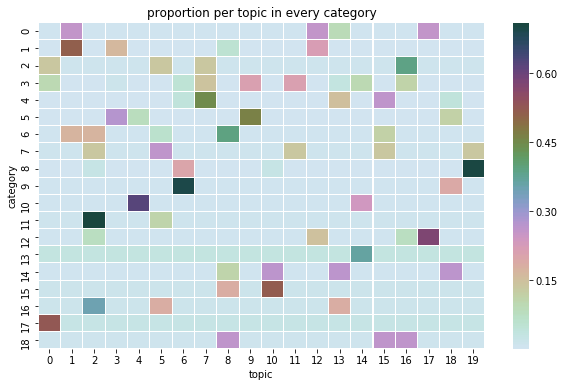

In [23]:
doc_topic = model.doc_topic_
plot_topic(doc_topic)